Creation Date: 02/12/2026

In [47]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shapely.geometry import MultiPoint
from scipy.spatial import Delaunay
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union, polygonize

import geopandas as gpd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

data_path = "/data1/peerd/mezallj1/basal_ablation/data"

In [16]:
def plot_lesion(adata, lesion_id):
    mask = adata.obs['global_duct_cluster'] == lesion_id
    coords = adata[mask].obsm['X_spatial']

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(coords[:, 0], coords[:, 1], s=5)
    ax.set_title(f'Cluster: {lesion_id}')
    ax.set_aspect('equal')
    plt.show()
    

In [17]:
def plot_area_lesion(adata, lesion_id, margin=0.5, polygon=None):
    cluster_mask = adata.obs['global_duct_cluster'] == lesion_id
    cluster_coords = adata[cluster_mask].obsm['X_spatial']

    # bounding box of cluster cells + input padding
    xmin, ymin = cluster_coords.min(axis=0)
    xmax, ymax = cluster_coords.max(axis=0)
    xpad = (xmax - xmin) * margin
    ypad = (ymax - ymin) * margin

    all_coords = adata.obsm['X_spatial']
    bbox_mask = (
        (all_coords[:, 0] >= xmin - xpad) & (all_coords[:, 0] <= xmax + xpad) &
        (all_coords[:, 1] >= ymin - ypad) & (all_coords[:, 1] <= ymax + ypad)
    )

    sub = adata[bbox_mask].copy()
    sub.obs['is_cluster'] = (sub.obs['global_duct_cluster'] == lesion_id).astype(str)

    fig, ax = plt.subplots(figsize=(8, 8))
    coords_sub = sub.obsm['X_spatial']
    colors = sub.obs['is_cluster'].map({'True': 'tab:orange', 'False': 'lightgrey'})
    ax.scatter(coords_sub[:, 0], coords_sub[:, 1], s=5, c=colors, zorder=1)

    if polygon is not None:
        poly_original, poly_buffered = polygon

        def _plot_poly(poly, ax, **kwargs):
            if hasattr(poly, 'geoms'):
                for geom in poly.geoms:
                    if hasattr(geom, 'exterior'):
                        ax.plot(*geom.exterior.xy, **kwargs)
            elif hasattr(poly, 'exterior'):
                ax.plot(*poly.exterior.xy, **kwargs)

        _plot_poly(poly_original, ax, color='red', linewidth=2, label='Original', zorder=2)
        _plot_poly(poly_buffered, ax, color='blue', linewidth=1.5, linestyle='--', label='Buffered', zorder=2)
        ax.legend()

    ax.set_title(lesion_id)
    ax.set_aspect('equal')
    plt.show()

In [8]:
def robust_alphashape(coords, alpha=None):
    """
    Compute the alpha shape (concave hull) of a set of points.

    coords: List of (x, y) tuples or numpy array.
    alpha: alpha value.
           If None, it attempts to guess a 'tight' fit based on edge lengths.
           Higher alpha = Tighter fit (more holes).
           Lower alpha = Looser fit (closer to convex hull).
    """
    # 1. Validation & Deduplication
    if len(coords) < 4:
        from shapely.geometry import MultiPoint

        return MultiPoint(coords).convex_hull

    coords = np.array(coords)
    # Deduplicate
    coords = np.unique(coords, axis=0)

    # 2. Delaunay Triangulation
    tri = Delaunay(coords)

    # 3. Calculate Circumradii for all triangles
    # Formula: radius = (a * b * c) / (4 * area)
    # We do this vectorized for speed

    pa = coords[tri.simplices[:, 0]]
    pb = coords[tri.simplices[:, 1]]
    pc = coords[tri.simplices[:, 2]]

    # Side lengths
    a = np.sqrt(np.sum((pa - pb) ** 2, axis=1))
    b = np.sqrt(np.sum((pb - pc) ** 2, axis=1))
    c = np.sqrt(np.sum((pc - pa) ** 2, axis=1))

    # Area (Heron's formula)
    s = (a + b + c) / 2.0
    area = np.sqrt(np.maximum(s * (s - a) * (s - b) * (s - c), 1e-9))  # clamp >0

    # Circumradius
    circum_r = (a * b * c) / (4.0 * area + 1e-9)

    # 4. Determine Alpha if Auto
    if alpha is None:
        # Heuristic: Use the 90th percentile of circumradii as the threshold
        # This usually gives a shape that captures the main body but ignores outliers
        # (1/alpha) is the radius threshold.
        # So we filter out triangles larger than this radius.
        filter_radius = np.percentile(circum_r, 90)
    else:
        filter_radius = 1.0 / alpha

    # 5. Filter Triangles
    # Keep triangles small enough (radius < threshold)
    valid_mask = circum_r < filter_radius
    valid_simplices = tri.simplices[valid_mask]

    if len(valid_simplices) == 0:
        # Fallback if alpha is too high (everything filtered out)
        from shapely.geometry import MultiPoint

        return MultiPoint(coords).convex_hull

    # 6. Construct Geometry
    # Create Shapely polygons for valid triangles and union them
    polys = []
    for simplex in valid_simplices:
        pts = coords[simplex]
        polys.append(Polygon(pts))

    # Efficient Union
    final_poly = unary_union(polys)

    # 7. Clean up (Fill small internal holes if desired, or return as is)
    # Often alphashapes have tiny internal holes. You might want just the exterior.
    # If you want strictly the outer boundary:
    # return Polygon(final_poly.exterior)

    return final_poly

In [48]:
def get_lesion_boundary(adata, lesion_id, spatial_key='X_spatial', alpha=None, buffer_pct=0.10):
    """
    Compute the boundary polygon for a single lesion from an AnnData object.

    Parameters
    ----------
    adata : AnnData
        Must have `global_duct_cluster` in .obs and spatial coordinates in .obsm[spatial_key].
    lesion_id : str
        Value in adata.obs['global_duct_cluster'] identifying the lesion.
    spatial_key : str
        Key in adata.obsm for spatial coordinates.
    alpha : float or None
        Alpha parameter for alpha shape. None uses auto-heuristic (90th percentile).
    buffer_pct : float
        Fractional expansion of the boundary for the buffered polygon (0.10 = 10%).

    Returns
    -------
    (poly_original, poly_buffered) : tuple of shapely Polygons, or (None, None) if too few cells.
    """
    mask = adata.obs['global_duct_cluster'] == lesion_id
    indices = np.where(mask)[0]

    if len(indices) < 4:
        print(f"Too few cells ({len(indices)}) for lesion '{lesion_id}'")
        return None, None

    coords = adata.obsm[spatial_key][indices]

    try:
        poly_original = robust_alphashape(coords, alpha=alpha)
    except Exception as e:
        print(f"Alphashape failed for '{lesion_id}': {e}, falling back to convex hull")
        poly_original = MultiPoint(coords).convex_hull

    if poly_original is None or poly_original.is_empty:
        return None, None

    if buffer_pct > 0:
        scale_factor = np.sqrt(poly_original.area)
        poly_buffered = poly_original.buffer(scale_factor * buffer_pct).buffer(0)
    else:
        poly_buffered = poly_original

    return poly_original, poly_buffered

In [57]:
def assign_cells_by_polygon(adata, spatial_key='X_spatial', alpha=None, buffer_pct=0.10):
    """
    For each lesion in adata.obs['global_duct_cluster'], compute the buffered polygon
    and reassign all cells that fall within it. Creates three new columns:
      - polygon_global_duct_cluster
      - polygon_lesion_num
      - polygon_lesion_id

    Cells inside multiple buffered polygons are assigned to the nearest (smallest area) one.
    Cells inside none remain NaN.
    """
    # build lookup from global_duct_cluster -> (lesion_num, lesion_id)
    meta = (
        adata.obs.dropna(subset=['global_duct_cluster']) # Only cares about NaNs in this column
        [['global_duct_cluster', 'lesion_num', 'lesion_id']] # Column selection
        .drop_duplicates('global_duct_cluster') # Keep one row (lesion) per cluster
        .set_index('global_duct_cluster') # Make clusters the index
    )

    # build GeoDataFrame of all cell points once (current cells coordinates)
    all_coords = adata.obsm[spatial_key]
    gdf_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(all_coords[:, 0], all_coords[:, 1]),
        index=adata.obs_names,
    )

    lesion_ids = meta.index.tolist() # List of unique lesion identifiers (global_duct_cluster values)

    # compute buffered polygons for all lesions
    polys = {}
    for lid in tqdm(lesion_ids, desc="Computing boundaries"):
        result = get_lesion_boundary(adata, lid, spatial_key=spatial_key, alpha=alpha, buffer_pct=buffer_pct)
        if result[1] is not None:
            polys[lid] = result[1]  # buffered polygon

    # spatial join: for each polygon, find cells within it
    # collect (cell_barcode, lesion, polygon_area) to resolve overlaps
    assignments = []
    for lid, poly_buff in tqdm(polys.items(), desc="Assigning cells"):
        poly_gdf = gpd.GeoDataFrame(geometry=[poly_buff])
        hits = gpd.sjoin(gdf_points, poly_gdf, predicate='within') # checks points that are inside the polygon, boundary is not a match
        for barcode in hits.index:
            assignments.append((barcode, lid, poly_buff.area))

    # resolve overlaps: keep the smallest polygon (most specific lesion)
    df_assign = pd.DataFrame(assignments, columns=['barcode', 'global_duct_cluster', 'poly_area'])
    df_assign = df_assign.sort_values('poly_area').drop_duplicates('barcode', keep='first') # keeps smaller polygon size as it should represent more specific features
    df_assign = df_assign.set_index('barcode')

    # map back to lesion_num and lesion_id
    adata.obs['polygon_global_duct_cluster'] = df_assign['global_duct_cluster'].reindex(adata.obs_names)
    adata.obs['polygon_lesion_num'] = (
        df_assign['global_duct_cluster']
        .map(meta['lesion_num']) # indexed by global_duct_cluster, returns lesion_num
        .reindex(adata.obs_names)
    )
    adata.obs['polygon_lesion_id'] = (
        df_assign['global_duct_cluster']
        .map(meta['lesion_id']) # indexed by global_duct_cluster, returns lesion_id
        .reindex(adata.obs_names)
    )

    n_original = adata.obs['global_duct_cluster'].notna().sum()
    n_polygon = adata.obs['polygon_global_duct_cluster'].notna().sum()
    print(f"Original assignments: {n_original} cells")
    print(f"Polygon assignments:  {n_polygon} cells (+{n_polygon - n_original} new) which is {((n_polygon - n_original) / n_original * 100):.1f}% increase")

In [59]:
def export_groups_csv(adata, column_key, sample_id, save_path):
    """
    Export a CSV with cell_id and group columns, excluding cells without an assignment.

    Parameters
    ----------
    adata : AnnData
        The annotated data object.
    column_key : str
        Column name in adata.obs to use as group assignment.
    sample_id : str
        Sample ID string to strip from barcodes (e.g. '2__0032813_Region_3').
        cell_id is derived by splitting the barcode on sample_id and keeping the first part.
    save_path : str
        File path to save the CSV.
    """
    df = pd.DataFrame({
        'cell_id': adata.obs_names.str.split(sample_id).str[0].str.rstrip('-'),
        'group': adata.obs[column_key].values,
    })
    df = df.dropna(subset=['group']) # Only export cells with an assigned group dependent on the column key
    df.to_csv(save_path, index=False)
    print(f"Saved {len(df)} rows to {save_path}")

## Day 1 Lessions

### Full New Annotations based on Buffered Polygons

In [61]:
d1_id = "5__0032783_Region_2"
d1_adata = sc.read_h5ad(f'{data_path}/{d1_id}_with_lesion_metadata_20260212.h5ad')

In [62]:
assign_cells_by_polygon(d1_adata, spatial_key='X_spatial', alpha=None, buffer_pct=0.10)

Assigning cells: 100%|██████████| 1045/1045 [00:07<00:00, 133.51it/s]


Original assignments: 61635 cells
Polygon assignments:  116447 cells (+54812 new) which is 88.9% increase


In [63]:
d1_adata.write_h5ad(f'{data_path}/{d1_id}_with_polygon_lesion_annotations_20260212.h5ad')

In [64]:
export_groups_csv(d1_adata, 'polygon_global_duct_cluster', d1_id, f'{data_path}/annotations/{d1_id}_polygon_lesion_annotations_20260212.csv')

Saved 116447 rows to /data1/peerd/mezallj1/basal_ablation/data/annotations/5__0032783_Region_2_polygon_lesion_annotations_20260212.csv


### Specific Lessions

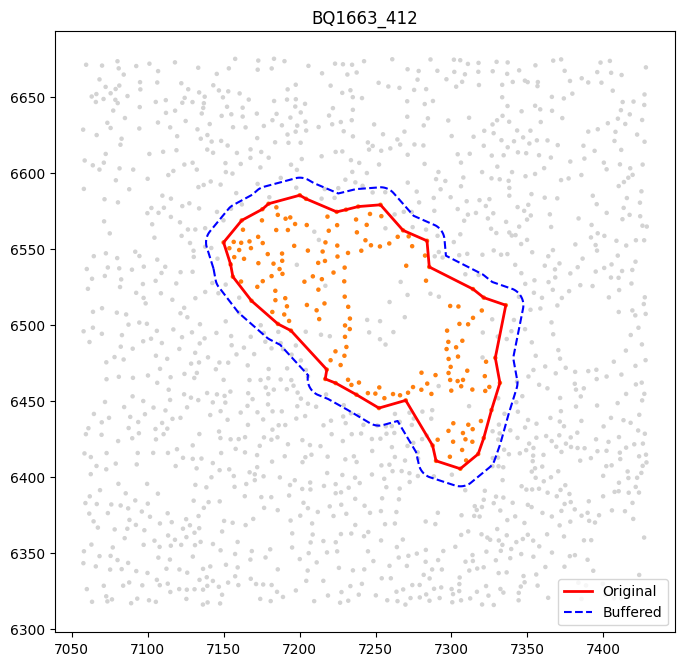

In [67]:
poly = get_lesion_boundary(d1_adata, 'BQ1663_412', buffer_pct=0.10)
plot_area_lesion(d1_adata, 'BQ1663_412', polygon=poly)

In [85]:
poly[0].from_bounds

<bound method Polygon.from_bounds of <class 'shapely.geometry.polygon.Polygon'>>

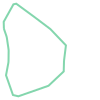

In [72]:
poly[1].interiors[0]

## Day 0 Lessions

### Full New Annotations based on Buffered Polygons

In [50]:
d0_id = "2__0032813_Region_3"
d0_adata = sc.read_h5ad(f'{data_path}/{d0_id}_with_lesion_metadata_20260212.h5ad')

In [51]:
assign_cells_by_polygon(d0_adata, spatial_key='X_spatial', alpha=None, buffer_pct=0.10)

Assigning cells: 100%|██████████| 365/365 [00:01<00:00, 240.70it/s]


Original assignments: 18609 cells
Polygon assignments:  41895 cells (+23286 new)


In [65]:
d0_adata.write_h5ad(f'{data_path}/{d0_id}_with_polygon_lesion_annotations_20260212.h5ad')

In [60]:
export_groups_csv(d0_adata, 'polygon_global_duct_cluster', d0_id, f'{data_path}/annotations/{d0_id}_polygon_lesion_annotations_20260212.csv')

Saved 41895 rows to /data1/peerd/mezallj1/basal_ablation/data/annotations/2__0032813_Region_3_polygon_lesion_annotations_20260212.csv


### Specific Lessions

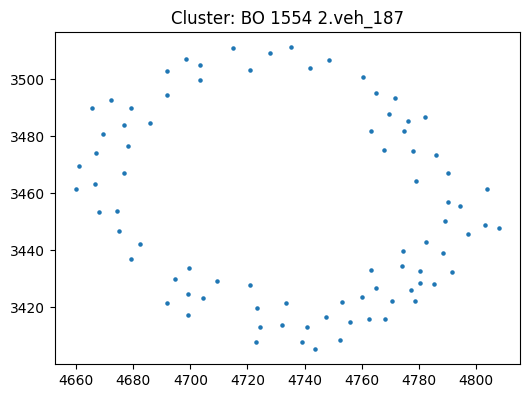

In [11]:
plot_lesion(d0_adata, 'BO 1554 2.veh_187')

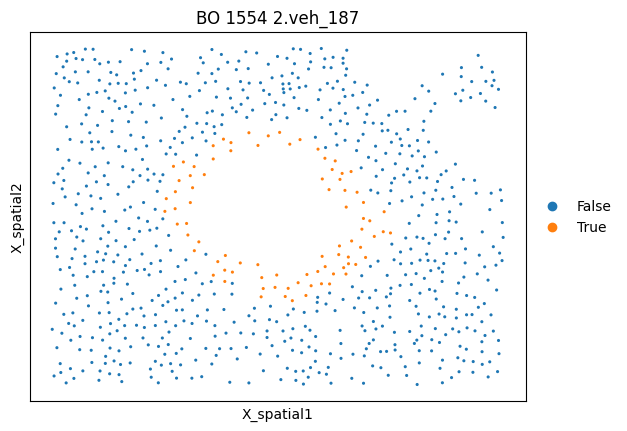

In [12]:
plot_area_lesion(d0_adata, 'BO 1554 2.veh_187', margin=0.5)

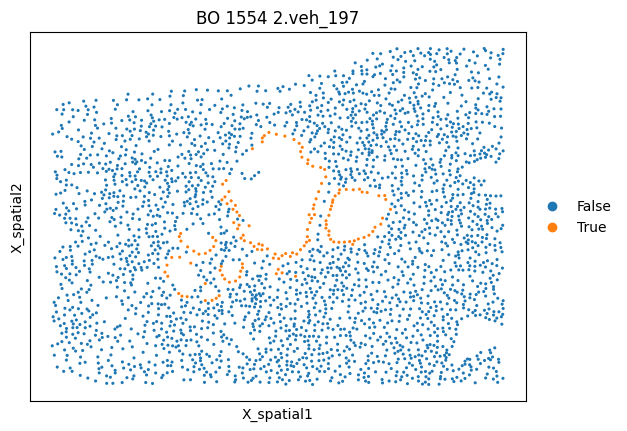

In [13]:
plot_area_lesion(d0_adata, 'BO 1554 2.veh_197')

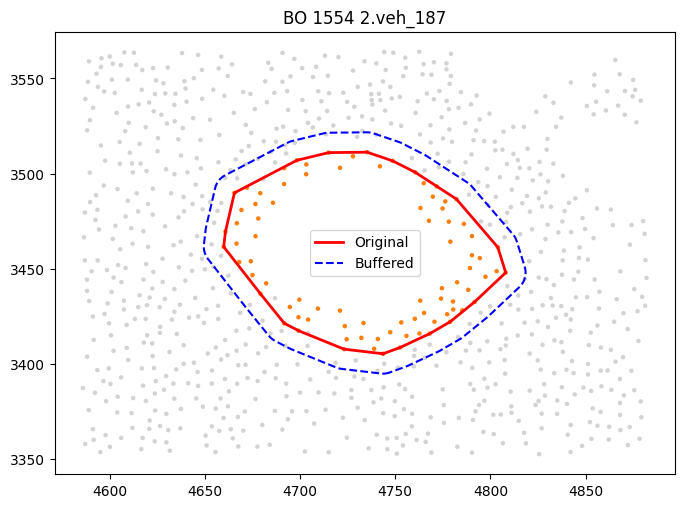

In [21]:
poly = get_lesion_boundary(d0_adata, 'BO 1554 2.veh_187', alpha=20, buffer_pct=0.10)
plot_area_lesion(d0_adata, 'BO 1554 2.veh_187', polygon=poly)

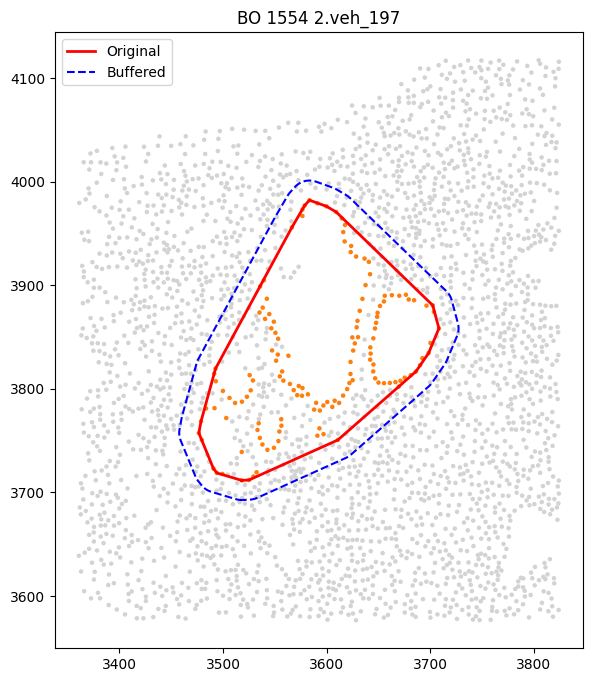

In [23]:
poly = get_lesion_boundary(d0_adata, 'BO 1554 2.veh_197', alpha=20, buffer_pct=0.10)
plot_area_lesion(d0_adata, 'BO 1554 2.veh_197', polygon=poly)

In [37]:
d0_adata.obs

,dataset,sample_id,barcode,index,sample_name,condition,condition_num,experiment,run,slide,...,predicted_labels,over_clustering,majority_voting,conf_score,cell_annotation,contaminated,global_concat_phenograph,global_duct_cluster,lesion_num,lesion_id
barcode,,,,,,,,,,,,,,,,,,,,,
aechklgn-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,aechklgn-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Epithelial,122,Epithelial,1.000000,Cancer_epithelial,False,18,BO 1554 2.veh_26,26.0,2__0032813_Region_3:26
aebhfddd-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,aebhfddd-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Epithelial,122,Epithelial,1.000000,Cancer_epithelial,False,18,BO 1554 2.veh_26,26.0,2__0032813_Region_3:26
adkoebfj-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,adkoebfj-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Epithelial,122,Epithelial,1.000000,Cancer_epithelial,False,18,BO 1554 2.veh_26,26.0,2__0032813_Region_3:26
aecomjlg-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,aecomjlg-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Epithelial,122,Epithelial,1.000000,Cancer_epithelial,False,18,BO 1554 2.veh_26,26.0,2__0032813_Region_3:26
adkgoedh-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,adkgoedh-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Fibroblast,11,Epithelial,0.000003,Cancer_mesenchymal,False,11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kdhjpfee-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,kdhjpfee-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Fibroblast,64,MuralCells,0.991400,Fibroblast,False,2,NaN,NaN,NaN
kdhglmie-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,kdhglmie-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Fibroblast,81,Fibroblast,0.204816,Fibroblast,False,4,NaN,NaN,NaN
kdhmanhd-1-2__0032813_Region_3,2__0032813_Region_3,2__0032813_Region_3,kdhmanhd-1-2__0032813_Region_3,39,BO 1554 2.veh,Vehicle,0.0,KI,2,:0032813,...,Fibroblast,81,Fibroblast,0.765625,Fibroblast,False,4,NaN,NaN,NaN


In [40]:
meta = (
        d0_adata.obs.dropna(subset=['global_duct_cluster']) # Only cares about NaNs in this column
        [['global_duct_cluster', 'lesion_num', 'lesion_id']]
        .drop_duplicates('global_duct_cluster')
        .set_index('global_duct_cluster')
    )

In [41]:
meta

,lesion_num,lesion_id
global_duct_cluster,,
BO 1554 2.veh_26,26.0,2__0032813_Region_3:26
BO 1554 2.veh_17,17.0,2__0032813_Region_3:17
BO 1554 2.veh_3,3.0,2__0032813_Region_3:3
BO 1554 2.veh_5,5.0,2__0032813_Region_3:5
BO 1554 2.veh_36,36.0,2__0032813_Region_3:36
...,...,...
BO 1554 2.veh_91,91.0,2__0032813_Region_3:91
BO 1554 2.veh_92,92.0,2__0032813_Region_3:92
BO 1554 2.veh_171,171.0,2__0032813_Region_3:171
